In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Load the CSV file
df = pd.read_csv('online_retail_II.csv', encoding='ISO-8859-1')

# Show the first 5 rows
df.head()


Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [45]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [46]:
# Count how many rows have empty strings in 'Invoice'
(df['Invoice'] == '').sum()


np.int64(0)

In [47]:
# Check column names
print("Columns:", df.columns.tolist())


Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


In [48]:
# Check number of rows and columns
print("Shape:", df.shape)

Shape: (1067371, 8)


In [49]:
# Count missing values per column
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [50]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['Customer ID'])

In [51]:
# Confirm changes
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [52]:
# Filter out canceled transactions
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [53]:
# Keep only positive Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [54]:
# Drop duplicate rows
df = df.drop_duplicates()

In [55]:
# Confirm
df.duplicated().sum()

np.int64(0)

In [56]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Check data types
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [57]:
# Check number of rows and columns
print("Shape:", df.shape)

Shape: (779425, 8)


Code for RFM Analysis

In [58]:
# Snapshot date = 1 day after the latest invoice date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2011-12-10 12:50:00')

In [59]:
# Group by Customer ID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'Price': 'sum'                                            # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display RFM table
rfm.head()


CustomerID  Recency  Frequency  Monetary
0     12346.0      326         12    207.40
1     12347.0        2          8    554.57
2     12348.0       75          5    193.10
3     12349.0       19          4   1480.44
4     12350.0      310          1     65.30

In [60]:
# Score each metric from 1 (worst) to 5 (best)
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine into RFM score
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

rfm.head()


CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Score
0     12346.0      326         12    207.40  2  5  3       253
1     12347.0        2          8    554.57  5  4  5       545
2     12348.0       75          5    193.10  3  4  3       343
3     12349.0       19          4   1480.44  5  3  5       535
4     12350.0      310          1     65.30  2  1  2       212

Histogram of Recency, Frequency, Monetary

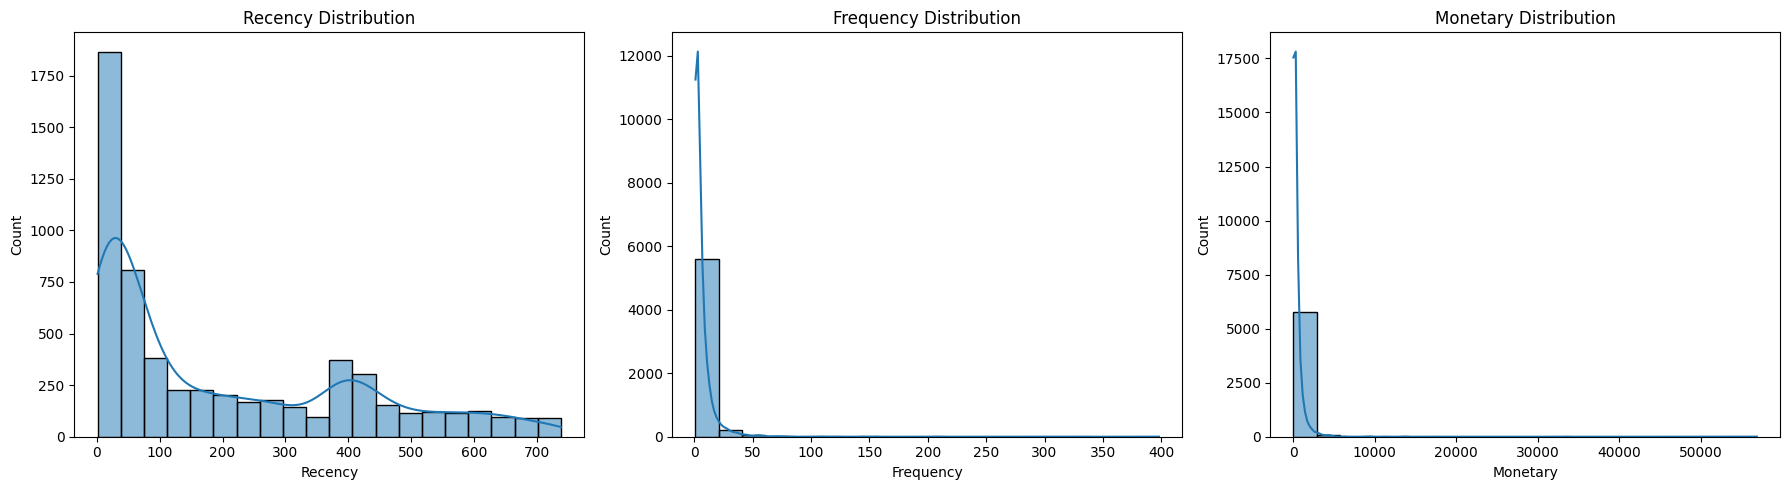

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()
